In [ ]:
# Install all packages
# Restart runtime after installation

#!wget https://github.com/PranjalSahu/ITKThinShellDemons/raw/pranjal_setup/itk_thinshelldemons-0.1.1-cp38-cp38m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
#!pip install itk_thinshelldemons-0.1.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
#!pip install itk_thinshelldemons-0.1.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install itk_thinshelldemons-0.1.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install itk==5.3rc4
!pip install vtk
!pip install itkwidgets

In [1]:
# Import all packages

import numpy as np
#import itkConfig
#itkConfig.LazyLoading = False
import itk
import vtk
import itkwidgets
import math
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
import time
import copy

from vtk.util import numpy_support
from vtk.util.numpy_support import numpy_to_vtk
# To enable itkwidgets window
#from google.colab import output
#output.enable_custom_widget_manager()

In [2]:
# Helper Functions

def subsample_points(inputmesh, mesh_sub_sample_points, seed):
    import vtk
    from vtk.util import numpy_support

    sample = vtk.vtkPolyDataPointSampler()
    sample.SetInputData(inputmesh)
    sample.SetGenerateEdgePoints(0)
    sample.SetGenerateInteriorPoints(0)
    sample.SetPointGenerationModeToRegular()
    sample.SetDistance(0.5)
    sample.Update()

    sampled_points = sample.GetOutput()

    points = sampled_points.GetPoints()
    pointdata = points.GetData()

    as_numpy = numpy_support.vtk_to_numpy(pointdata)
    
    np.random.seed(seed)
    random_indices = np.random.choice(as_numpy.shape[0],
                                      size=mesh_sub_sample_points,
                                      replace=False)
    as_numpy_sampled = as_numpy[random_indices, :]

    return as_numpy_sampled

def subsample_points_poisson(inputMesh):
    import vtk
    from vtk.util import numpy_support

    f = vtk.vtkPoissonDiskSampler()
    f.SetInputData(inputMesh)
    f.SetRadius(4.5)
    f.Update()
    
    sampled_points = f.GetOutput()
    points = sampled_points.GetPoints()
    pointdata = points.GetData()

    as_numpy = numpy_support.vtk_to_numpy(pointdata)
    
    return as_numpy

def readvtk(filename):
    a = vtk.vtkPolyDataReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

def readply(filename):
    a = vtk.vtkPLYReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

#MOVING_MESH_FILE = '/data/Apedata/CorrectData/data/Pan/meshes/USNM220065-Cranium_merged_1.ply'
#FIXED_MESH_FILE  = '/data/Apedata/CorrectData/data/Gorilla/meshes/USNM252575-Cranium.ply'

# ransac registered
MOVING_MESH_FILE = '/home/pranjal.sahu/Documents/SampleApeData1/USNM174701-Cranium_merged_1.ply'
# original mesh
#MOVING_MESH_FILE = '/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium.ply'

FIXED_MESH_FILE  = '/home/pranjal.sahu/Documents/SampleApeData1/USNM174722-Cranium.ply'

paths = [FIXED_MESH_FILE, MOVING_MESH_FILE]

In [19]:
# Fetch the files

FIXED_MESH_FILE  = r'data/129S1_SVIMJ_.ply'
MOVING_MESH_FILE = r'data/129X1_SVJ_.ply'
paths = [FIXED_MESH_FILE, MOVING_MESH_FILE]

import os
import importlib
from urllib.request import urlretrieve

# Download meshes
os.makedirs('data',exist_ok=True)
if not os.path.exists(FIXED_MESH_FILE):
    url = 'https://github.com/SlicerMorph/Mouse_Models/raw/main/Models/129S1_SVIMJ_.ply'
    urlretrieve(url, FIXED_MESH_FILE)
if not os.path.exists(MOVING_MESH_FILE):
    url = 'https://github.com/SlicerMorph/Mouse_Models/raw/main/Models/129X1_SVJ_.ply'
    urlretrieve(url, MOVING_MESH_FILE)

In [12]:
# Clean the meshes and Triangulate them as TSD only works with Triangle Meshes

vtk_meshes = list()

for path in paths:
    reader = vtk.vtkPLYReader()
    reader.SetFileName(path)
    reader.Update()
        
    cleaner = vtk.vtkCleanPolyData()
    cleaner.SetInputData(reader.GetOutput())
    cleaner.ConvertLinesToPointsOn()
    cleaner.ConvertPolysToLinesOff()
    cleaner.SetTolerance(0.0)
    cleaner.Update()
    vtk_mesh = cleaner.GetOutput()

    triangle_filter = vtk.vtkTriangleFilter()
    triangle_filter.SetInputData(vtk_mesh)
    triangle_filter.SetPassLines(False)
    triangle_filter.SetPassVerts(False)
    triangle_filter.Update()
    vtk_mesh = triangle_filter.GetOutput()
    
    vtk_meshes.append(vtk_mesh)
    
# Write back out to a filetype supported by ITK
vtk_paths = [path.strip('.ply') + '.vtk' for path in paths]
for idx, mesh in enumerate(vtk_meshes):
    writer = vtk.vtkPolyDataWriter()
    writer.SetInputData(mesh)
    writer.SetFileVersion(42)
    writer.SetFileTypeToBinary()
    writer.SetFileName(vtk_paths[idx])
    writer.Update()
    
itk_meshes = [itk.meshread(path, pixel_type=itk.D) for path in vtk_paths]

In [13]:
# Convert meshes to images for performing moment based initialization

itk_transformed_meshes= []
# itk_meshes = []
# itk_meshes.append(itk.meshread('itk_meshes_0.vtk'))
# itk_meshes.append(itk.meshread('itk_meshes_1.vtk'))

itk_images = []
for mesh in itk_meshes:
    # Get all the points to positive values
    temp = itk.array_from_vector_container(mesh.GetPoints())
    m    = np.min(temp, 0)
    temp = temp - m
    mesh.SetPoints(itk.vector_container_from_array(temp.flatten())) 
    
    itk_transformed_meshes.append(mesh)
    itk_image = itk.triangle_mesh_to_binary_image_filter(mesh,
                                                      origin=[0, 0, 0],
                                                      spacing=[1, 1, 1],
                                                      size=[250, 250, 250])
    itk_images.append(itk_image)
                                                         

itk_transforms = list()

for image in itk_images:
    calculator = itk.ImageMomentsCalculator[type(image)].New()
    calculator.SetImage(image)
    calculator.Compute()
    itk_transforms.append(calculator.GetPhysicalAxesToPrincipalAxesTransform())

In [14]:
# Write the Moment based initialized meshes as vtk file

itk_transformed_meshes = [
    itk.transform_mesh_filter(mesh, transform=itk_transforms[idx])
    for idx, mesh in enumerate(itk_meshes)
]

fixedMesh  = itk_meshes[0]#itk_transformed_meshes[0]
movingMesh = itk_meshes[1]#itk_transformed_meshes[1]


w1 = itk.MeshFileWriter[type(movingMesh)].New()
w1.SetFileName('movingMesh.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(movingMesh)
w1.Update()

w1 = itk.MeshFileWriter[type(movingMesh)].New()
w1.SetFileName('fixedMesh.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(fixedMesh)
w1.Update()

#itk.meshwrite(movingMesh, 'movingMesh.vtk')
#itk.meshwrite(fixedMesh, 'fixedMesh.vtk')

In [15]:
def readvtk(filename):
    a = vtk.vtkPolyDataReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

fixedMesh = readvtk('fixedMesh.vtk')
movingMesh = readvtk('movingMesh.vtk')

In [3]:
# For performing RANSAC in parallel

from vtk.util import numpy_support
from vtk.util.numpy_support import numpy_to_vtk


def ransac_icp_parallel(fixedMeshPoints, movingMeshPoints, movingMeshAllPoints,
                        number_of_iterations, mesh_sub_sample_points,
                        number_of_ransac_points, transform_type,
                        convergance_value):
    import numpy as np
    np.random.seed(0)

    all_points1 = fixedMeshPoints
    all_points2 = movingMeshPoints

    def process(i, mesh_sub_sample_points, number_of_ransac_points,
                return_result):
        # Create Mesh inside the method to tackle the problem of serialization
        
        import itk
        
        mesh_fixed = itk.Mesh[itk.D, 3].New()
        mesh_moving = itk.Mesh[itk.D, 3].New()

        mesh_fixed.SetPoints(
            itk.vector_container_from_array(all_points1.flatten()))
        mesh_moving.SetPoints(
            itk.vector_container_from_array(all_points2.flatten()))

        ps1 = itk.Mesh[itk.D, 3].New()
        ps2 = itk.Mesh[itk.D, 3].New()
        
        # Create small point sets
        np.random.seed(i)
        random_indices = np.random.choice(all_points1.shape[0],
                                          size=number_of_ransac_points)
        p1_a = all_points1[random_indices, :]

        random_indices = np.random.choice(all_points2.shape[0],
                                          size=number_of_ransac_points)
        p2_a = all_points2[random_indices, :]

        ps1.SetPoints(itk.vector_container_from_array(p1_a.flatten()))
        ps2.SetPoints(itk.vector_container_from_array(p2_a.flatten()))

        if transform_type == 0:
            TransformType = itk.Euler3DTransform[itk.D]
        elif transform_type == 1:
            TransformType = itk.ScaleVersor3DTransform[itk.D]
        elif transform_type == 2:
            TransformType = itk.Similarity3DTransform[itk.D]
        else:
            TransformType = itk.AffineTransform[itk.D, 3]

        transform = TransformType.New()
        transform.SetIdentity()
        
        MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
        metric = MetricType.New()
        metric.SetMovingPointSet(ps2)
        metric.SetFixedPointSet(ps1)
        metric.SetMovingTransform(transform)
        metric.Initialize()
                
        optimizer = itk.ConjugateGradientLineSearchOptimizerv4Template[itk.D].New()
        optimizer.SetNumberOfIterations(20)
        optimizer.SetMaximumStepSizeInPhysicalUnits( 0.1 )
        optimizer.SetMinimumConvergenceValue( 0.0 )
        optimizer.SetConvergenceWindowSize( 20 )
        optimizer.SetMetric(metric)
        optimizer.StartOptimization()

        """
        optimizer = itk.GradientDescentOptimizerv4Template.D.New()
        optimizer.SetNumberOfIterations(200)
        optimizer.SetLearningRate(0.1)
        optimizer.SetMaximumStepSizeInPhysicalUnits( 0.1 )
        optimizer.SetMinimumConvergenceValue( 0.0 )
        optimizer.SetConvergenceWindowSize( 200 )
        optimizer.SetMetric(metric)
        optimizer.StartOptimization()
        """
        
        current_transform = metric.GetTransform()
        itk_transformed_mesh = itk.transform_mesh_filter(
            mesh_moving, transform=current_transform)

        e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
        e_metric.SetFixedPointSet(mesh_fixed)
        e_metric.SetMovingPointSet(itk_transformed_mesh)
        e_metric.Initialize()

        current_value = e_metric.GetValue()
        #current_transform = itk.dict_from_transform(current_transform)

        if return_result:
            mesh_moving = itk.Mesh[itk.D, 3].New()
            #mesh_moving.SetPoints(
            #    itk.vector_container_from_array(movingMeshAllPoints.flatten()))
            mesh_moving.SetPoints(
                itk.vector_container_from_array(movingMeshPoints.flatten()))
            
            itk_transformed_mesh = itk.transform_mesh_filter(
                mesh_moving, transform=current_transform)
            
            return itk.array_from_vector_container(
                itk_transformed_mesh.GetPoints())
        else:
            return (current_value, i)
        #if current_value < 7:
        #    return (current_value, i)
        #else:
        #    return (current_value, -1)

    results = Parallel(n_jobs=8)(
        delayed(process)(i, mesh_sub_sample_points, number_of_ransac_points, 0)
        for i in range(number_of_iterations))
    results = sorted(results)

    print(results[0])
    final_result = process(results[0][1], mesh_sub_sample_points,
                           number_of_ransac_points, 1)
    #movingMesh.SetPoints(itk.vector_container_from_array(final_result.flatten()))
    
    return final_result

import time

number_of_iterations = 1000
number_of_ransac_points = 500
mesh_sub_sample_points = 5000
convergence_value = 3
transform_type = 0

movingMesh = readvtk('movingMesh.vtk')
fixedMesh  = readvtk('fixedMesh.vtk')

movingMeshAllPoints = numpy_support.vtk_to_numpy(
    movingMesh.GetPoints().GetData())

movingMeshPoints = subsample_points_poisson(movingMesh)
fixedMeshPoints  = subsample_points_poisson(fixedMesh)

print(fixedMeshPoints.shape)

def get_bounding_box_data(inputMeshPoints):
    ElementIdentifierType = itk.UL
    CoordType = itk.F
    Dimension = 3

    VecContType = itk.VectorContainer[
        ElementIdentifierType, itk.Point[CoordType, Dimension]
    ]

    ps = itk.PointSet.D3.New()
    ps.SetPoints(itk.vector_container_from_array(inputMeshPoints.flatten()))

    bounding_box = itk.BoundingBox[ElementIdentifierType, Dimension, CoordType, VecContType].New()
    bounding_box.SetPoints(ps.GetPoints())
    bounding_box.ComputeBoundingBox()

    minBounds = np.array(bounding_box.GetMinimum())
    maxBounds = np.array(bounding_box.GetMaximum())
    
    return maxBounds - minBounds, bounding_box.GetCenter()

def perform_scaling_and_centering(movingMeshPoints, fixedMeshPoints):
    md1, cm1 = get_bounding_box_data(movingMeshPoints)
    fd1, cf1 = get_bounding_box_data(fixedMeshPoints)
    
    transform = itk.ScaleTransform.D3.New()
    transform.SetScale([fd1[0]/md1[0], fd1[1]/md1[1], fd1[2]/md1[2]])
    transform.SetCenter(cm1)

    ps = itk.Mesh.D3.New()
    ps.SetPoints(itk.vector_container_from_array(movingMeshPoints.flatten()))

    scaledMovingMeshPoints = itk.transform_mesh_filter(ps, transform=transform)
    scaledMovingMeshPoints = itk.array_from_vector_container(scaledMovingMeshPoints.GetPoints())
    scaledMovingMeshPoints = scaledMovingMeshPoints - cm1 + cf1
    return scaledMovingMeshPoints.astype('float32')

movingMeshPoints = perform_scaling_and_centering(movingMeshPoints, fixedMeshPoints)

print(movingMeshPoints.shape)

start_time = time.time()
itk_transformed_points = ransac_icp_parallel(fixedMeshPoints, movingMeshPoints,
                                             movingMeshAllPoints,
                                             number_of_iterations,
                                             mesh_sub_sample_points,
                                             number_of_ransac_points,
                                             transform_type, convergence_value)
end_time = time.time()

print(end_time - start_time)
print('itk_transformed_points shape ', itk_transformed_points.shape)

#itk_transformed_mesh = itk.meshread('movingMesh.vtk')
#itk_transformed_mesh.SetPoints(
#    itk.vector_container_from_array(itk_transformed_points.flatten()))

newmesh = itk.Mesh.D3.New()
newmesh.SetPoints(itk.vector_container_from_array(itk_transformed_points.flatten()))

w1 = itk.MeshFileWriter[type(newmesh)].New()
w1.SetFileName('ransacICPResult2_b.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(newmesh)
w1.Update()

(8002, 3)
(3754, 3)
(9.157837577253037, 548)
163.64065885543823
itk_transformed_points shape  (3754, 3)


In [ ]:
# Findings
# Optimizing with Similarity transform which has both scale and rotation is slower.
# Better to perform re-sacling first and then performing the optimization.

In [4]:
print(movingMeshPoints.shape)
print(fixedMeshPoints.shape)
print(itk_transformed_points.shape)

(3754, 3)
(8002, 3)
(3754, 3)


In [5]:
# Visualize the results after RANSAC ICP

from itkwidgets import view

def readvtk(filename):
    a = vtk.vtkPolyDataReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

def readply(filename):
    a = vtk.vtkPLYReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

#m1 = readvtk('fixedMesh.vtk')
#m2 = readvtk('movingMesh.vtk')
#m3 = readvtk('ransacICPResult1_b.vtk')
#m4 = readvtk('ransacICPResult1_c.vtk')


#m1 = readvtk('/home/pranjal.sahu/Documents/SampleApeData/USNM174701-Cranium_merged_1.vtk')
#m2 = readvtk('/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium_1.vtk')

#m1 = readvtk('fixedMesh.vtk')
#m2 = readvtk('movingMesh.vtk')
#m3 = readvtk('ransacICPResult2_b.vtk')
#m3 = readply('/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium_1.ply')
#m4 = readvtk('ransacICPResult2_b.vtk')


view(point_sets=[fixedMeshPoints, movingMeshPoints, itk_transformed_points])

Viewer(geometries=[], gradient_opacity=0.22, point_set_colors=array([[0.8392157 , 0.        , 0.        ],
   …

In [18]:
# [STAR] Expectation Based PointSetToPointSetMetricv4 Registration

import copy
from vtk.util import numpy_support

imageDiagonal = 100

PixelType = itk.D
Dimension = 3

FixedImageType = itk.Image[PixelType, Dimension]

#fixedMeshPath  = '/home/pranjal.sahu/Documents/SampleApeData/USNM174701-Cranium_merged_1.vtk'
# fixedMeshPath  = 'fixedMesh.vtk'
# movingMeshPath = 'ransacICPResult2_b.vtk'
# #movingMeshPath = readvtk('/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium_1.vtk')

# # Read the meshes
# fixedMesh  = readvtk(fixedMeshPath)
# movingMesh = readvtk(movingMeshPath)


# movingMeshAllPoints = copy.deepcopy(numpy_support.vtk_to_numpy(
#     movingMesh.GetPoints().GetData()))

# fixedMeshAllPoints = copy.deepcopy(numpy_support.vtk_to_numpy(
#     fixedMesh.GetPoints().GetData()))

#print(movingMeshAllPoints.shape)
#print(fixedMeshAllPoints.shape)

# movingMeshPoints = subsample_points_poisson(movingMesh)
# fixedMeshPoints = subsample_points_poisson(fixedMesh)

print(movingMeshPoints.shape)
print(fixedMeshPoints.shape)

# Create PointSets for registration
movingPS = itk.PointSet[itk.D, Dimension].New()
fixedPS = itk.PointSet[itk.D, Dimension].New()

movingPS.SetPoints(itk.vector_container_from_array(movingMeshPoints.flatten()))
fixedPS.SetPoints(itk.vector_container_from_array(fixedMeshPoints.flatten()))


#movingMeshPath = 'ransacICPResult2_b.vtk'
#itk.meshwrite(movingMeshPath, movingPS)


# For getting the Bounding Box
ElementIdentifierType = itk.UL
CoordType = itk.F
Dimension = 3

VecContType = itk.VectorContainer[ElementIdentifierType, itk.Point[CoordType,
                                                                   Dimension]]
bounding_box = itk.BoundingBox[ElementIdentifierType, Dimension, CoordType,
                               VecContType].New()

#all_points = np.concatenate([itk.array_from_vector_container(movingPS.GetPoints()), itk.array_from_vector_container(movingPS.GetPoints())])

bounding_box.SetPoints(fixedPS.GetPoints())
bounding_box.ComputeBoundingBox()

minBounds = np.array(bounding_box.GetMinimum())
maxBounds = np.array(bounding_box.GetMaximum())

spacing = np.sqrt(bounding_box.GetDiagonalLength2()) / imageDiagonal
diff = maxBounds - minBounds

print('Spacing ', spacing)
print('minBounds ', minBounds)
print('maxBounds ', maxBounds)

fixedImageSize = [0] * 3
fixedImageSize[0] = math.ceil(1.25 * diff[0] / spacing)
fixedImageSize[1] = math.ceil(1.25 * diff[1] / spacing)
fixedImageSize[2] = math.ceil(1.25 * diff[2] / spacing)

fixedImageOrigin = [0] * 3
fixedImageOrigin[0] = minBounds[0] - 0.25 * diff[0]
fixedImageOrigin[1] = minBounds[1] - 0.25 * diff[1]
fixedImageOrigin[2] = minBounds[2] - 0.25 * diff[2]

fixedImageSpacing = np.ones(3) * spacing
fixedImageDirection = np.identity(3)

fixedImage = FixedImageType.New()
fixedImage.SetRegions(fixedImageSize)
fixedImage.SetOrigin(fixedImageOrigin)
fixedImage.SetDirection(fixedImageDirection)
fixedImage.SetSpacing(fixedImageSpacing)
fixedImage.Allocate()



# Create BSpline Transformation object and initialize the parameters
SplineOrder = 3
TransformType = itk.BSplineTransform[itk.D, Dimension, SplineOrder]
InitializerType = itk.BSplineTransformInitializer[TransformType,
                                                  FixedImageType]

transform = TransformType.New()

# Higher the grid dimensio, slower the computation but higher will be the accuracy
# Increasing the grid nodes is not working
numberOfGridNodesInOneDimension = 8
transformInitializer = InitializerType.New()
transformInitializer.SetTransform(transform)
transformInitializer.SetImage(fixedImage)
transformInitializer.SetTransformDomainMeshSize(
    numberOfGridNodesInOneDimension - SplineOrder)
transformInitializer.InitializeTransform()



# Registration Loop
numOfIterations = 20000
maxStep = 0.1
learningRate = 0.1

MetricType = itk.ExpectationBasedPointSetToPointSetMetricv4[type(movingPS)]
metric = MetricType.New()
metric.SetFixedPointSet(movingPS)
metric.SetMovingPointSet(fixedPS)
metric.SetPointSetSigma(1)
metric.SetEvaluationKNeighborhood(10)
metric.SetMovingTransform(transform)
metric.Initialize()

print('Metric Created')

optimizer = itk.RegularStepGradientDescentOptimizerv4.D.New()
optimizer.SetNumberOfIterations(numOfIterations)
optimizer.SetMaximumStepSizeInPhysicalUnits(maxStep)
optimizer.SetLearningRate(learningRate)
optimizer.SetMinimumConvergenceValue(-100)
optimizer.SetConvergenceWindowSize(numOfIterations)
optimizer.SetMetric(metric)

def iteration_update():
    metric_value = optimizer.GetValue()
    current_parameters = optimizer.GetCurrentPosition()
    print(f"Metric: {metric_value:.8g}")


iteration_command = itk.PyCommand.New()
iteration_command.SetCommandCallable(iteration_update)
optimizer.AddObserver(itk.IterationEvent(), iteration_command)

optimizer.StartOptimization()


# Transform the point set using the final transform
final_transform = metric.GetMovingTransform()

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedPS)
e_metric.SetMovingPointSet(movingPS)
print('Euclidean Metric Before TSD Deformable Registration ', e_metric.GetValue())


movingPSNew = itk.PointSet[itk.D, 3].New()
numberOfPoints = movingPS.GetNumberOfPoints()

for n in range(0, numberOfPoints):
    movingPSNew.SetPoint(n, final_transform.TransformPoint(movingPS.GetPoint(n)))

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedPS)
e_metric.SetMovingPointSet(movingPSNew)
print('Euclidean Metric After TSD Deformable Registration ', e_metric.GetValue())


# # Write the mesh to disk
# movingMeshITK = itk.meshread(movingMeshPath, itk.D)
# numberOfPoints = movingMeshITK.GetNumberOfPoints()
# for n in range(0, numberOfPoints):
#     movingMeshITK.SetPoint(n, final_transform.TransformPoint(movingMeshITK.GetPoint(n)))
    

# w1 = itk.MeshFileWriter[type(movingMeshITK)].New()
# w1.SetFileName('ransacICPResult2_c_check.vtk')
# w1.SetFileTypeAsBINARY()
# w1.SetInput(movingMeshITK)
# w1.Update()

# # Write the Displacement Field

# convertFilter = itk.TransformToDisplacementFieldFilter.IVF33D.New()
# convertFilter.SetTransform(final_transform)
# convertFilter.UseReferenceImageOn()
# convertFilter.SetReferenceImage(fixedImage)
# convertFilter.Update()
# field = convertFilter.GetOutput()
# field = np.array(field)
# np.save('displacement_field.npy', field)

(3754, 3)
(8002, 3)
Spacing  3.592885385122242
minBounds  [0.09823608 0.09112549 0.22616577]
maxBounds  [169.47674561 288.01483154 132.51037598]
Metric Created
Metric: -0.017612249
Metric: -0.017617337
Metric: -0.01762208
Metric: -0.01762586
Metric: -0.017628755
Metric: -0.017631537
Metric: -0.017634399
Metric: -0.017637407
Metric: -0.017640633
Metric: -0.017644091
Metric: -0.017647828
Metric: -0.017651857
Metric: -0.017656167
Metric: -0.017660744
Metric: -0.017665569
Metric: -0.017670608
Metric: -0.017675816
Metric: -0.017681153
Metric: -0.017686561
Metric: -0.017691994
Metric: -0.017697353
Metric: -0.017702588
Metric: -0.017707618
Metric: -0.017712416
Metric: -0.017716974
Metric: -0.017721364
Metric: -0.017725681
Metric: -0.017730058
Metric: -0.017734566
Metric: -0.017739226
Metric: -0.017743976
Metric: -0.01774883
Metric: -0.017753885
Metric: -0.017759137
Metric: -0.017764417
Metric: -0.017769578
Metric: -0.017774439
Metric: -0.017778942
Metric: -0.017782982
Metric: -0.017786641
Met

Metric: -0.018124069
Metric: -0.018124685
Metric: -0.018125471
Metric: -0.01812599
Metric: -0.018126869
Metric: -0.018127216
Metric: -0.018128287
Metric: -0.01812838
Metric: -0.018129629
Metric: -0.018129529
Metric: -0.018130851
Metric: -0.018130704
Metric: -0.018132065
Metric: -0.018131948
Metric: -0.018133349
Metric: -0.018133245
Metric: -0.018134672
Metric: -0.018134586
Metric: -0.018136029
Metric: -0.018135926
Metric: -0.018137375
Metric: -0.018137256
Metric: -0.018138699
Metric: -0.018138548
Metric: -0.01813998
Metric: -0.018139795
Metric: -0.01814121
Metric: -0.018140974
Metric: -0.018142365
Metric: -0.018142081
Metric: -0.018143443
Metric: -0.018143116
Metric: -0.018144439
Metric: -0.018144048
Metric: -0.018145348
Metric: -0.018144901
Metric: -0.018146163
Metric: -0.018145661
Metric: -0.018146879
Metric: -0.018146315
Metric: -0.0181475
Metric: -0.018146881
Metric: -0.018148019
Metric: -0.018147346
Metric: -0.018148451
Metric: -0.018147716
Metric: -0.018148783
Metric: -0.01814799

Metric: -0.018097564
Metric: -0.018098134
Metric: -0.018098679
Metric: -0.018099194
Metric: -0.018099681
Metric: -0.018100149
Metric: -0.018100591
Metric: -0.018101022
Metric: -0.018101434
Metric: -0.018101832
Metric: -0.018102216
Metric: -0.018102595
Metric: -0.018102958
Metric: -0.018103324
Metric: -0.01810368
Metric: -0.018104034
Metric: -0.018104385
Metric: -0.018104732
Metric: -0.018105088
Metric: -0.018105442
Metric: -0.018105797
Metric: -0.01810616
Metric: -0.018106526
Metric: -0.018106899
Metric: -0.018107285
Metric: -0.018107674
Metric: -0.018108073
Metric: -0.018108486
Metric: -0.018108906
Metric: -0.018109348
Metric: -0.018109795
Metric: -0.018110256
Metric: -0.018110731
Metric: -0.018111228
Metric: -0.018111735
Metric: -0.018112258
Metric: -0.018112807
Metric: -0.018113368
Metric: -0.018113943
Metric: -0.018114544
Metric: -0.018115161
Metric: -0.018115799
Metric: -0.018116453
Metric: -0.018117127
Metric: -0.018117826
Metric: -0.018118547
Metric: -0.018119279
Metric: -0.0181

Metric: -0.018360149
Metric: -0.018360069
Metric: -0.018359999
Metric: -0.018359924
Metric: -0.018359844
Metric: -0.018359768
Metric: -0.018359691
Metric: -0.018359616
Metric: -0.01835954
Metric: -0.018359465
Metric: -0.018359389
Metric: -0.018359314
Metric: -0.018359232
Metric: -0.01835916
Metric: -0.018359076
Metric: -0.018359003
Metric: -0.018358911
Metric: -0.01835883
Metric: -0.018358743
Metric: -0.018358659
Metric: -0.018358578
Metric: -0.018358489
Metric: -0.018358396
Metric: -0.018358305
Metric: -0.018358209
Metric: -0.018358117
Metric: -0.018358021
Metric: -0.018357924
Metric: -0.018357815
Metric: -0.01835772
Metric: -0.018357609
Metric: -0.018357501
Metric: -0.018357396
Metric: -0.018357288
Metric: -0.018357163
Metric: -0.018357056
Metric: -0.018356933
Metric: -0.018356817
Metric: -0.018356695
Metric: -0.018356573
Metric: -0.018356445
Metric: -0.018356308
Metric: -0.01835618
Metric: -0.018356051
Metric: -0.018355909
Metric: -0.018355763
Metric: -0.018355624
Metric: -0.0183554

Metric: -0.018582429
Metric: -0.018583504
Metric: -0.018584616
Metric: -0.018585721
Metric: -0.018586832
Metric: -0.018587935
Metric: -0.018589032
Metric: -0.018590142
Metric: -0.018591243
Metric: -0.018592343
Metric: -0.018593445
Metric: -0.018594546
Metric: -0.01859565
Metric: -0.018596756
Metric: -0.018597852
Metric: -0.018598956
Metric: -0.018600055
Metric: -0.018601156
Metric: -0.018602257
Metric: -0.018603358
Metric: -0.018604461
Metric: -0.018605553
Metric: -0.018606661
Metric: -0.018607755
Metric: -0.018608848
Metric: -0.018609947
Metric: -0.018611045
Metric: -0.018612134
Metric: -0.018613229
Metric: -0.018614324
Metric: -0.018615419
Metric: -0.018616502
Metric: -0.018617589
Metric: -0.018618678
Metric: -0.018619762
Metric: -0.018620843
Metric: -0.018621927
Metric: -0.018623002
Metric: -0.018624083
Metric: -0.018625158
Metric: -0.018626231
Metric: -0.0186273
Metric: -0.018628372
Metric: -0.018629443
Metric: -0.018630503
Metric: -0.018631568
Metric: -0.018632628
Metric: -0.01863

Metric: -0.018646922
Metric: -0.018647771
Metric: -0.01864867
Metric: -0.018649602
Metric: -0.018650565
Metric: -0.018651567
Metric: -0.0186526
Metric: -0.018653666
Metric: -0.01865476
Metric: -0.018655896
Metric: -0.018657047
Metric: -0.018658226
Metric: -0.018659443
Metric: -0.018660691
Metric: -0.01866196
Metric: -0.018663266
Metric: -0.018664601
Metric: -0.018665965
Metric: -0.018667368
Metric: -0.018668803
Metric: -0.01867027
Metric: -0.018671775
Metric: -0.018673322
Metric: -0.018674907
Metric: -0.018676541
Metric: -0.018678226
Metric: -0.018679904
Metric: -0.018681625
Metric: -0.018683399
Metric: -0.018685222
Metric: -0.018687096
Metric: -0.018689025
Metric: -0.018691009
Metric: -0.018693048
Metric: -0.018695148
Metric: -0.018697302
Metric: -0.018699522
Metric: -0.018701804
Metric: -0.018704143
Metric: -0.018706545
Metric: -0.018709014
Metric: -0.018711535
Metric: -0.018714121
Metric: -0.018716754
Metric: -0.018719443
Metric: -0.018722184
Metric: -0.018724973
Metric: -0.01872781

Metric: -0.019569885
Metric: -0.019568598
Metric: -0.019567314
Metric: -0.019566021
Metric: -0.01956473
Metric: -0.019563449
Metric: -0.01956218
Metric: -0.019560919
Metric: -0.019559679
Metric: -0.01955846
Metric: -0.019557267
Metric: -0.019556101
Metric: -0.019554961
Metric: -0.019553853
Metric: -0.019552778
Metric: -0.019551741
Metric: -0.019550735
Metric: -0.019549772
Metric: -0.019548835
Metric: -0.019547947
Metric: -0.01954709
Metric: -0.019546277
Metric: -0.019545511
Metric: -0.01954478
Metric: -0.019544097
Metric: -0.019543455
Metric: -0.01954286
Metric: -0.019542308
Metric: -0.01954181
Metric: -0.019541358
Metric: -0.019540945
Metric: -0.019540586
Metric: -0.01954028
Metric: -0.019540013
Metric: -0.019539789
Metric: -0.019539624
Metric: -0.019539495
Metric: -0.019539419
Metric: -0.019539376
Metric: -0.019539383
Metric: -0.019539419
Metric: -0.0195395
Metric: -0.019539613
Metric: -0.019539757
Metric: -0.019539934
Metric: -0.019540141
Metric: -0.019540377
Metric: -0.019540628
Me

Metric: -0.019740292
Metric: -0.019740842
Metric: -0.019741362
Metric: -0.019741858
Metric: -0.019742323
Metric: -0.019742769
Metric: -0.01974319
Metric: -0.019743583
Metric: -0.01974395
Metric: -0.019744286
Metric: -0.019744604
Metric: -0.019744906
Metric: -0.01974518
Metric: -0.019745433
Metric: -0.019745662
Metric: -0.019745882
Metric: -0.019746072
Metric: -0.019746253
Metric: -0.019746405
Metric: -0.019746546
Metric: -0.019746669
Metric: -0.019746779
Metric: -0.019746877
Metric: -0.019746957
Metric: -0.019747024
Metric: -0.019747075
Metric: -0.019747125
Metric: -0.019747151
Metric: -0.019747179
Metric: -0.019747189
Metric: -0.019747195
Metric: -0.019747181
Metric: -0.019747164
Metric: -0.019747141
Metric: -0.019747107
Metric: -0.019747052
Metric: -0.019746996
Metric: -0.01974693
Metric: -0.019749532
Metric: -0.019752132
Metric: -0.019754729
Metric: -0.019757321
Metric: -0.01975991
Metric: -0.019762496
Metric: -0.01976507
Metric: -0.019767642
Metric: -0.019770209
Metric: -0.01977275

Metric: -0.019937605
Metric: -0.019937564
Metric: -0.019937525
Metric: -0.019937502
Metric: -0.019937475
Metric: -0.019937463
Metric: -0.019937453
Metric: -0.019937446
Metric: -0.019937448
Metric: -0.01993745
Metric: -0.019937464
Metric: -0.019937473
Metric: -0.019937485
Metric: -0.019937505
Metric: -0.01993753
Metric: -0.019937553
Metric: -0.019937579
Metric: -0.019937606
Metric: -0.019937636
Metric: -0.019937678
Metric: -0.019937702
Metric: -0.01993774
Metric: -0.019937778
Metric: -0.019937817
Metric: -0.019937853
Metric: -0.019937901
Metric: -0.019937944
Metric: -0.019937988
Metric: -0.019938035
Metric: -0.01993808
Metric: -0.01993813
Metric: -0.019938182
Metric: -0.019938235
Metric: -0.019938281
Metric: -0.019938331
Metric: -0.019938398
Metric: -0.019938453
Metric: -0.019938515
Metric: -0.019938572
Metric: -0.019938631
Metric: -0.019938695
Metric: -0.019938757
Metric: -0.019938823
Metric: -0.019938888
Metric: -0.019938958
Metric: -0.019939025
Metric: -0.019939087
Metric: -0.0199391

Metric: -0.020036824
Metric: -0.020038329
Metric: -0.020039845
Metric: -0.020041368
Metric: -0.020042888
Metric: -0.020044415
Metric: -0.020045942
Metric: -0.020047469
Metric: -0.020048992
Metric: -0.020050526
Metric: -0.020052051
Metric: -0.020053586
Metric: -0.020055106
Metric: -0.020056628
Metric: -0.020058145
Metric: -0.020059653
Metric: -0.020061158
Metric: -0.02006265
Metric: -0.020064141
Metric: -0.020065617
Metric: -0.020067076
Metric: -0.020068534
Metric: -0.020069961
Metric: -0.020071384
Metric: -0.02007279
Metric: -0.020074175
Metric: -0.020075542
Metric: -0.020076886
Metric: -0.020078212
Metric: -0.020079515
Metric: -0.020080797
Metric: -0.020082054
Metric: -0.020083286
Metric: -0.020084496
Metric: -0.020085675
Metric: -0.020086829
Metric: -0.02008796
Metric: -0.020089054
Metric: -0.020090134
Metric: -0.020091165
Metric: -0.020092171
Metric: -0.020093152
Metric: -0.020094089
Metric: -0.020095005
Metric: -0.020095887
Metric: -0.020096726
Metric: -0.020097526
Metric: -0.02009

Metric: -0.020066988
Metric: -0.020066189
Metric: -0.020065382
Metric: -0.020064589
Metric: -0.020063837
Metric: -0.020063122
Metric: -0.020062486
Metric: -0.020061948
Metric: -0.020061538
Metric: -0.020061272
Metric: -0.020061186
Metric: -0.020061247
Metric: -0.020061482
Metric: -0.020061825
Metric: -0.020062339
Metric: -0.020062838
Metric: -0.020063586
Metric: -0.020064111
Metric: -0.020065102
Metric: -0.020065423
Metric: -0.020066675
Metric: -0.020066642
Metric: -0.020068022
Metric: -0.020067888
Metric: -0.020069268
Metric: -0.020069131
Metric: -0.020070496
Metric: -0.020070345
Metric: -0.020071693
Metric: -0.020071528
Metric: -0.020072835
Metric: -0.020072653
Metric: -0.020073923
Metric: -0.020073729
Metric: -0.020074955
Metric: -0.020074743
Metric: -0.020075913
Metric: -0.020075684
Metric: -0.020076816
Metric: -0.02007656
Metric: -0.020077636
Metric: -0.020077382
Metric: -0.020078408
Metric: -0.020078149
Metric: -0.020079122
Metric: -0.020078865
Metric: -0.020079801
Metric: -0.020

Metric: -0.020057966
Metric: -0.020058378
Metric: -0.020058804
Metric: -0.020059239
Metric: -0.020059687
Metric: -0.020060141
Metric: -0.020060625
Metric: -0.020061115
Metric: -0.020061614
Metric: -0.02006214
Metric: -0.020062675
Metric: -0.020063224
Metric: -0.020063796
Metric: -0.020064383
Metric: -0.020064994
Metric: -0.020065626
Metric: -0.020066266
Metric: -0.020066938
Metric: -0.020067619
Metric: -0.020068328
Metric: -0.020069038
Metric: -0.02006977
Metric: -0.02007052
Metric: -0.020071282
Metric: -0.020072061
Metric: -0.020072852
Metric: -0.020073653
Metric: -0.020074459
Metric: -0.020075284
Metric: -0.020076118
Metric: -0.020076942
Metric: -0.020077787
Metric: -0.020078629
Metric: -0.020079473
Metric: -0.02008032
Metric: -0.020081166
Metric: -0.020082011
Metric: -0.020082853
Metric: -0.020083692
Metric: -0.02008452
Metric: -0.020085355
Metric: -0.020086177
Metric: -0.020087
Metric: -0.020087811
Metric: -0.020088608
Metric: -0.020089407
Metric: -0.020090196
Metric: -0.020090966


Metric: -0.020427198
Metric: -0.02042885
Metric: -0.020430475
Metric: -0.020432086
Metric: -0.020433667
Metric: -0.020435238
Metric: -0.020436782
Metric: -0.020438322
Metric: -0.02043984
Metric: -0.020441346
Metric: -0.020442835
Metric: -0.020444312
Metric: -0.020445781
Metric: -0.020447244
Metric: -0.020448697
Metric: -0.020450137
Metric: -0.020451582
Metric: -0.020453
Metric: -0.020454433
Metric: -0.020455856
Metric: -0.020457264
Metric: -0.020458674
Metric: -0.020460084
Metric: -0.020461487
Metric: -0.02046289
Metric: -0.020464278
Metric: -0.020465662
Metric: -0.020467046
Metric: -0.020468423
Metric: -0.0204698
Metric: -0.020471171
Metric: -0.020472536
Metric: -0.020473897
Metric: -0.020475248
Metric: -0.020476603
Metric: -0.02047795
Metric: -0.020479296
Metric: -0.02048063
Metric: -0.020481958
Metric: -0.020483281
Metric: -0.020484599
Metric: -0.020485913
Metric: -0.020487215
Metric: -0.020488512
Metric: -0.020489808
Metric: -0.020491091
Metric: -0.020492369
Metric: -0.020493632
Me

Metric: -0.020645965
Metric: -0.020646697
Metric: -0.020647438
Metric: -0.020648181
Metric: -0.020648925
Metric: -0.020649674
Metric: -0.020650419
Metric: -0.02065118
Metric: -0.020651933
Metric: -0.020652684
Metric: -0.02065344
Metric: -0.020654193
Metric: -0.020654948
Metric: -0.020655717
Metric: -0.020656495
Metric: -0.020657269
Metric: -0.020658037
Metric: -0.020658802
Metric: -0.020659564
Metric: -0.020660323
Metric: -0.020661091
Metric: -0.020661849
Metric: -0.02066259
Metric: -0.020663325
Metric: -0.020664058
Metric: -0.020664775
Metric: -0.020665488
Metric: -0.020666193
Metric: -0.020666882
Metric: -0.020667574
Metric: -0.020668246
Metric: -0.020668902
Metric: -0.020669552
Metric: -0.020670193
Metric: -0.020670823
Metric: -0.020671437
Metric: -0.020672036
Metric: -0.020672624
Metric: -0.020673194
Metric: -0.020673759
Metric: -0.020674333
Metric: -0.02067488
Metric: -0.020675407
Metric: -0.020675912
Metric: -0.020676398
Metric: -0.020676876
Metric: -0.020677323
Metric: -0.020677

Metric: -0.02081867
Metric: -0.020819652
Metric: -0.020820626
Metric: -0.020821597
Metric: -0.020822557
Metric: -0.020823506
Metric: -0.020824448
Metric: -0.020825385
Metric: -0.020826303
Metric: -0.020827215
Metric: -0.020828117
Metric: -0.020829001
Metric: -0.020829873
Metric: -0.020830734
Metric: -0.02083159
Metric: -0.020832423
Metric: -0.020833246
Metric: -0.020834054
Metric: -0.02083484
Metric: -0.020835616
Metric: -0.020836378
Metric: -0.020837112
Metric: -0.020837838
Metric: -0.020838541
Metric: -0.020839236
Metric: -0.020839902
Metric: -0.020840548
Metric: -0.020841188
Metric: -0.020841796
Metric: -0.020842387
Metric: -0.020842953
Metric: -0.020843498
Metric: -0.020844035
Metric: -0.020844529
Metric: -0.020845022
Metric: -0.020845497
Metric: -0.020845943
Metric: -0.020846374
Metric: -0.020846782
Metric: -0.020847173
Metric: -0.020847538
Metric: -0.020847915
Metric: -0.020848264
Metric: -0.020848604
Metric: -0.020848918
Metric: -0.020849205
Metric: -0.020849484
Metric: -0.02084

Metric: -0.021035273
Metric: -0.021037554
Metric: -0.021039834
Metric: -0.021042083
Metric: -0.021044329
Metric: -0.021046555
Metric: -0.021048772
Metric: -0.021050972
Metric: -0.021053147
Metric: -0.021055315
Metric: -0.021057467
Metric: -0.021059601
Metric: -0.021061725
Metric: -0.021063834
Metric: -0.021065915
Metric: -0.02106801
Metric: -0.021070097
Metric: -0.021072153
Metric: -0.021074199
Metric: -0.021076227
Metric: -0.021078238
Metric: -0.021080243
Metric: -0.021082225
Metric: -0.021084189
Metric: -0.021086144
Metric: -0.021088079
Metric: -0.021089999
Metric: -0.021091907
Metric: -0.021093797
Metric: -0.021095678
Metric: -0.021097539
Metric: -0.021099393
Metric: -0.02110123
Metric: -0.021103058
Metric: -0.021104866
Metric: -0.021106661
Metric: -0.021108443
Metric: -0.021110217
Metric: -0.021111972
Metric: -0.021113711
Metric: -0.021115446
Metric: -0.021117167
Metric: -0.021118874
Metric: -0.021120573
Metric: -0.021122254
Metric: -0.021123936
Metric: -0.021125589
Metric: -0.0211

Metric: -0.021329778
Metric: -0.021331335
Metric: -0.021332887
Metric: -0.021334443
Metric: -0.021335971
Metric: -0.021337496
Metric: -0.021339
Metric: -0.021340503
Metric: -0.021341982
Metric: -0.021343462
Metric: -0.021344918
Metric: -0.021346367
Metric: -0.021347802
Metric: -0.021349236
Metric: -0.021350654
Metric: -0.021352074
Metric: -0.021353486
Metric: -0.021354886
Metric: -0.021356286
Metric: -0.021357681
Metric: -0.021359068
Metric: -0.021360447
Metric: -0.021361826
Metric: -0.021363205
Metric: -0.021364568
Metric: -0.021365927
Metric: -0.021367285
Metric: -0.021368619
Metric: -0.021369958
Metric: -0.021371274
Metric: -0.021372588
Metric: -0.021373878
Metric: -0.021375157
Metric: -0.021376414
Metric: -0.021377653
Metric: -0.021378879
Metric: -0.021380071
Metric: -0.021381253
Metric: -0.021382407
Metric: -0.021383543
Metric: -0.021384653
Metric: -0.021385731
Metric: -0.021386785
Metric: -0.021387821
Metric: -0.021388834
Metric: -0.021389819
Metric: -0.021390773
Metric: -0.02139

Metric: -0.021373051
Metric: -0.021372622
Metric: -0.021372188
Metric: -0.021371762
Metric: -0.02137134
Metric: -0.021370927
Metric: -0.021370512
Metric: -0.021370106
Metric: -0.021369712
Metric: -0.021369307
Metric: -0.021368916
Metric: -0.021368519
Metric: -0.021368127
Metric: -0.021367745
Metric: -0.021367365
Metric: -0.021366988
Metric: -0.021366617
Metric: -0.02136625
Metric: -0.021365881
Metric: -0.021365524
Metric: -0.021365168
Metric: -0.02136482
Metric: -0.021364464
Metric: -0.021364123
Metric: -0.021363788
Metric: -0.021363444
Metric: -0.021363117
Metric: -0.021362789
Metric: -0.02136247
Metric: -0.021362155
Metric: -0.021361834
Metric: -0.021361519
Metric: -0.021361215
Metric: -0.021360906
Metric: -0.021360616
Metric: -0.021360316
Metric: -0.021360028
Metric: -0.021359749
Metric: -0.021359458
Metric: -0.02135918
Metric: -0.021358916
Metric: -0.021358637
Metric: -0.021358369
Metric: -0.021358116
Metric: -0.02135786
Metric: -0.021357605
Metric: -0.021357362
Metric: -0.02135711

Metric: -0.021498979
Metric: -0.02149994
Metric: -0.021500887
Metric: -0.021501809
Metric: -0.021502699
Metric: -0.021503563
Metric: -0.021504406
Metric: -0.021505229
Metric: -0.021506027
Metric: -0.021506812
Metric: -0.021507575
Metric: -0.021508332
Metric: -0.021509061
Metric: -0.021509779
Metric: -0.02151048
Metric: -0.021511168
Metric: -0.021511845
Metric: -0.021512503
Metric: -0.021513159
Metric: -0.021513799
Metric: -0.021514436
Metric: -0.021515064
Metric: -0.021515685
Metric: -0.021516311
Metric: -0.021516922
Metric: -0.021517537
Metric: -0.021518147
Metric: -0.021518759
Metric: -0.021519372
Metric: -0.021519986
Metric: -0.021520616
Metric: -0.021521233
Metric: -0.021521875
Metric: -0.021522511
Metric: -0.021523164
Metric: -0.021523835
Metric: -0.021524491
Metric: -0.021525179
Metric: -0.021525883
Metric: -0.021526587
Metric: -0.021527311
Metric: -0.021528059
Metric: -0.021528827
Metric: -0.021529615
Metric: -0.021530414
Metric: -0.021531236
Metric: -0.021532067
Metric: -0.0215

Metric: -0.021558243
Metric: -0.021558576
Metric: -0.021558917
Metric: -0.021559278
Metric: -0.02155965
Metric: -0.021560039
Metric: -0.021560449
Metric: -0.021560863
Metric: -0.021561306
Metric: -0.021561759
Metric: -0.021562232
Metric: -0.021562722
Metric: -0.021563228
Metric: -0.021563757
Metric: -0.021564297
Metric: -0.021564862
Metric: -0.021565456
Metric: -0.021566055
Metric: -0.02156668
Metric: -0.021567327
Metric: -0.021568004
Metric: -0.021568687
Metric: -0.021569402
Metric: -0.02157014
Metric: -0.021570896
Metric: -0.021571683
Metric: -0.021572487
Metric: -0.021573322
Metric: -0.021574173
Metric: -0.021575063
Metric: -0.021575969
Metric: -0.021576898
Metric: -0.021577857
Metric: -0.021578845
Metric: -0.021579853
Metric: -0.021580891
Metric: -0.021581953
Metric: -0.021583046
Metric: -0.021584156
Metric: -0.021585302
Metric: -0.021586462
Metric: -0.021587653
Metric: -0.021588866
Metric: -0.021590101
Metric: -0.021591366
Metric: -0.021592652
Metric: -0.021593959
Metric: -0.02159

Metric: -0.022330892
Metric: -0.022332821
Metric: -0.022334762
Metric: -0.022336711
Metric: -0.022338654
Metric: -0.022340615
Metric: -0.022342568
Metric: -0.022344528
Metric: -0.022346488
Metric: -0.02234845
Metric: -0.02235041
Metric: -0.022352378
Metric: -0.022354335
Metric: -0.022356288
Metric: -0.02235825
Metric: -0.022360203
Metric: -0.022362149
Metric: -0.022364097
Metric: -0.022366031
Metric: -0.022367962
Metric: -0.022369897
Metric: -0.022371817
Metric: -0.022373733
Metric: -0.022375643
Metric: -0.022377547
Metric: -0.02237945
Metric: -0.022381337
Metric: -0.022383224
Metric: -0.022385106
Metric: -0.022386992
Metric: -0.022388867
Metric: -0.022390741
Metric: -0.022392619
Metric: -0.022394493
Metric: -0.02239637
Metric: -0.022398244
Metric: -0.02240013
Metric: -0.022402018
Metric: -0.02240391
Metric: -0.022405822
Metric: -0.022407741
Metric: -0.022409681
Metric: -0.02241163
Metric: -0.02241361
Metric: -0.022415607
Metric: -0.022417626
Metric: -0.022419679
Metric: -0.022421755
M

Metric: -0.023453302
Metric: -0.02345605
Metric: -0.023458766
Metric: -0.023461468
Metric: -0.023464127
Metric: -0.023466766
Metric: -0.023469369
Metric: -0.023471943
Metric: -0.023474489
Metric: -0.023476995
Metric: -0.02347947
Metric: -0.023481913
Metric: -0.023484321
Metric: -0.023486691
Metric: -0.023489019
Metric: -0.023491308
Metric: -0.023493563
Metric: -0.023495764
Metric: -0.023497923
Metric: -0.02350004
Metric: -0.023502115
Metric: -0.023504141
Metric: -0.023506124
Metric: -0.023508062
Metric: -0.023509954
Metric: -0.023511809
Metric: -0.023513612
Metric: -0.023515376
Metric: -0.023517095
Metric: -0.023518775
Metric: -0.023520418
Metric: -0.023522021
Metric: -0.023523585
Metric: -0.023525108
Metric: -0.023526607
Metric: -0.023528068
Metric: -0.023529498
Metric: -0.023530892
Metric: -0.023532261
Metric: -0.023533609
Metric: -0.023534924
Metric: -0.023536216
Metric: -0.023537486
Metric: -0.023538725
Metric: -0.023539945
Metric: -0.023541142
Metric: -0.023542319
Metric: -0.02354

Metric: -0.024157802
Metric: -0.02415811
Metric: -0.024158532
Metric: -0.024159017
Metric: -0.02415959
Metric: -0.0241602
Metric: -0.024160858
Metric: -0.024161568
Metric: -0.024162294
Metric: -0.024163053
Metric: -0.024163836
Metric: -0.024164636
Metric: -0.024165457
Metric: -0.024166294
Metric: -0.024167144
Metric: -0.024168007
Metric: -0.024168874
Metric: -0.02416975
Metric: -0.024170641
Metric: -0.02417153
Metric: -0.024172431
Metric: -0.024173338
Metric: -0.02417425
Metric: -0.024175173
Metric: -0.024176092
Metric: -0.024177024
Metric: -0.024177973
Metric: -0.024178916
Metric: -0.024179883
Metric: -0.024180848
Metric: -0.024181817
Metric: -0.024182804
Metric: -0.024183805
Metric: -0.024184814
Metric: -0.024185839
Metric: -0.024186877
Metric: -0.024187925
Metric: -0.024189
Metric: -0.024190079
Metric: -0.024191182
Metric: -0.024192293
Metric: -0.024193432
Metric: -0.024194583
Metric: -0.024195766
Metric: -0.02419696
Metric: -0.024198174
Metric: -0.024199413
Metric: -0.024200681
Met

Metric: -0.024644182
Metric: -0.02464577
Metric: -0.024647353
Metric: -0.024648942
Metric: -0.024650516
Metric: -0.024652086
Metric: -0.02465364
Metric: -0.024655191
Metric: -0.024656741
Metric: -0.024658272
Metric: -0.024659816
Metric: -0.024661347
Metric: -0.024662856
Metric: -0.024664361
Metric: -0.024665844
Metric: -0.02466731
Metric: -0.024668754
Metric: -0.024670189
Metric: -0.024671602
Metric: -0.024672997
Metric: -0.024674373
Metric: -0.024675733
Metric: -0.024677074
Metric: -0.024678392
Metric: -0.024679695
Metric: -0.024680974
Metric: -0.024682239
Metric: -0.024683496
Metric: -0.024684709
Metric: -0.024685924
Metric: -0.024687104
Metric: -0.024688274
Metric: -0.024689418
Metric: -0.024690551
Metric: -0.024691663
Metric: -0.02469277
Metric: -0.024693858
Metric: -0.024694918
Metric: -0.024695976
Metric: -0.02469701
Metric: -0.024698027
Metric: -0.024699037
Metric: -0.024700022
Metric: -0.024700996
Metric: -0.024701965
Metric: -0.024702913
Metric: -0.024703856
Metric: -0.0247047

Metric: -0.024827585
Metric: -0.024828045
Metric: -0.024828488
Metric: -0.02482893
Metric: -0.024829355
Metric: -0.024829766
Metric: -0.024830177
Metric: -0.024830563
Metric: -0.024830946
Metric: -0.024831324
Metric: -0.024831686
Metric: -0.024832036
Metric: -0.024832391
Metric: -0.024832717
Metric: -0.024833041
Metric: -0.024833355
Metric: -0.024833656
Metric: -0.024833952
Metric: -0.024834237
Metric: -0.024834504
Metric: -0.024834774
Metric: -0.024835033
Metric: -0.02483527
Metric: -0.024835513
Metric: -0.024835737
Metric: -0.024835953
Metric: -0.024836157
Metric: -0.024836359
Metric: -0.024836541
Metric: -0.024836717
Metric: -0.024836882
Metric: -0.024837027
Metric: -0.024837179
Metric: -0.024837306
Metric: -0.024837422
Metric: -0.024837535
Metric: -0.024837634
Metric: -0.024837713
Metric: -0.024837784
Metric: -0.024837834
Metric: -0.024837881
Metric: -0.024837902
Metric: -0.024837916
Metric: -0.024837913
Metric: -0.024837897
Metric: -0.024837852
Metric: -0.024837796
Metric: -0.0248

Metric: -0.024829992
Metric: -0.024830535
Metric: -0.02483108
Metric: -0.02483161
Metric: -0.024832147
Metric: -0.024832684
Metric: -0.024833229
Metric: -0.024833761
Metric: -0.024834307
Metric: -0.024834842
Metric: -0.024835381
Metric: -0.024835926
Metric: -0.024836472
Metric: -0.024837016
Metric: -0.024837561
Metric: -0.024838121
Metric: -0.024838664
Metric: -0.024839221
Metric: -0.024839774
Metric: -0.024840335
Metric: -0.024840896
Metric: -0.024841461
Metric: -0.024842023
Metric: -0.02484259
Metric: -0.02484316
Metric: -0.024843734
Metric: -0.024844299
Metric: -0.024844886
Metric: -0.02484547
Metric: -0.02484605
Metric: -0.024846639
Metric: -0.024847242
Metric: -0.02484783
Metric: -0.024848426
Metric: -0.024849032
Metric: -0.024849636
Metric: -0.024850248
Metric: -0.024850855
Metric: -0.024851472
Metric: -0.024852094
Metric: -0.024852719
Metric: -0.024853345
Metric: -0.024853971
Metric: -0.024854608
Metric: -0.02485524
Metric: -0.02485588
Metric: -0.024856536
Metric: -0.024857182
M

Metric: -0.025162041
Metric: -0.025163941
Metric: -0.025165849
Metric: -0.025167738
Metric: -0.025169628
Metric: -0.025171518
Metric: -0.025173395
Metric: -0.025175269
Metric: -0.025177145
Metric: -0.025179007
Metric: -0.025180865
Metric: -0.025182728
Metric: -0.02518458
Metric: -0.025186428
Metric: -0.025188275
Metric: -0.025190102
Metric: -0.025191931
Metric: -0.025193739
Metric: -0.025195546
Metric: -0.025197327
Metric: -0.025199091
Metric: -0.025200834
Metric: -0.02520255
Metric: -0.025204232
Metric: -0.025205867
Metric: -0.025207468
Metric: -0.025209007
Metric: -0.025210486
Metric: -0.025211898
Metric: -0.025213232
Metric: -0.025214496
Metric: -0.025215669
Metric: -0.02521677
Metric: -0.025217788
Metric: -0.025218739
Metric: -0.025219624
Metric: -0.02522046
Metric: -0.025221267
Metric: -0.025222033
Metric: -0.025222783
Metric: -0.025223514
Metric: -0.025224251
Metric: -0.02522498
Metric: -0.025225708
Metric: -0.025226453
Metric: -0.025227202
Metric: -0.025227958
Metric: -0.0252287

Metric: -0.025219076
Metric: -0.025218713
Metric: -0.025218326
Metric: -0.025217951
Metric: -0.025217563
Metric: -0.025217172
Metric: -0.025216775
Metric: -0.025216369
Metric: -0.025215961
Metric: -0.025215545
Metric: -0.025215135
Metric: -0.025214696
Metric: -0.025214274
Metric: -0.02521384
Metric: -0.025213394
Metric: -0.025212954
Metric: -0.025212499
Metric: -0.02521204
Metric: -0.025211573
Metric: -0.025211109
Metric: -0.025210646
Metric: -0.025210166
Metric: -0.025209698
Metric: -0.02520922
Metric: -0.025208742
Metric: -0.025208255
Metric: -0.025207769
Metric: -0.025207269
Metric: -0.025206776
Metric: -0.025206269
Metric: -0.025205765
Metric: -0.025205256
Metric: -0.025204741
Metric: -0.025204222
Metric: -0.025203709
Metric: -0.025203185
Metric: -0.025202666
Metric: -0.025202142
Metric: -0.025201619
Metric: -0.025201103
Metric: -0.025200583
Metric: -0.025200067
Metric: -0.025199555
Metric: -0.025199046
Metric: -0.025198533
Metric: -0.025198033
Metric: -0.02519753
Metric: -0.025197

Metric: -0.025129807
Metric: -0.025129569
Metric: -0.025129328
Metric: -0.025129093
Metric: -0.025128862
Metric: -0.025128646
Metric: -0.025128417
Metric: -0.025128202
Metric: -0.025127987
Metric: -0.025127767
Metric: -0.025127568
Metric: -0.025127368
Metric: -0.025127164
Metric: -0.025126966
Metric: -0.025126776
Metric: -0.025126581
Metric: -0.025126397
Metric: -0.025126216
Metric: -0.025126036
Metric: -0.025125856
Metric: -0.025125684
Metric: -0.025125515
Metric: -0.025125349
Metric: -0.025125187
Metric: -0.025125032
Metric: -0.025124875
Metric: -0.025124726
Metric: -0.025124577
Metric: -0.025124426
Metric: -0.025124287
Metric: -0.02512415
Metric: -0.025124013
Metric: -0.025123891
Metric: -0.025123762
Metric: -0.025123637
Metric: -0.025123519
Metric: -0.025123408
Metric: -0.02512329
Metric: -0.025123181
Metric: -0.025123079
Metric: -0.02512298
Metric: -0.025122888
Metric: -0.025122793
Metric: -0.025122707
Metric: -0.025122623
Metric: -0.025122549
Metric: -0.025122474
Metric: -0.02512

Metric: -0.025290834
Metric: -0.025291825
Metric: -0.025292833
Metric: -0.02529383
Metric: -0.025294817
Metric: -0.025295806
Metric: -0.025296794
Metric: -0.02529777
Metric: -0.025298745
Metric: -0.025299712
Metric: -0.025300678
Metric: -0.025301642
Metric: -0.025302595
Metric: -0.025303533
Metric: -0.025304484
Metric: -0.025305418
Metric: -0.025306347
Metric: -0.025307265
Metric: -0.025308189
Metric: -0.025309098
Metric: -0.025309994
Metric: -0.025310887
Metric: -0.025311669
Metric: -0.025312455
Metric: -0.025313216
Metric: -0.025313977
Metric: -0.025314733
Metric: -0.025315474
Metric: -0.025316202
Metric: -0.025316924
Metric: -0.025317639
Metric: -0.025318342
Metric: -0.025319026
Metric: -0.02531971
Metric: -0.025320384
Metric: -0.025321043
Metric: -0.025321678
Metric: -0.025322307
Metric: -0.025322934
Metric: -0.025323534
Metric: -0.025324127
Metric: -0.025324701
Metric: -0.025325267
Metric: -0.025325812
Metric: -0.025326345
Metric: -0.025326863
Metric: -0.025327368
Metric: -0.02532

Metric: -0.025285503
Metric: -0.025285514
Metric: -0.025285547
Metric: -0.025285604
Metric: -0.025285698
Metric: -0.02528581
Metric: -0.025285964
Metric: -0.025286134
Metric: -0.025286347
Metric: -0.025286605
Metric: -0.025286886
Metric: -0.025287203
Metric: -0.025287551
Metric: -0.025287919
Metric: -0.025288275
Metric: -0.025288644
Metric: -0.02528902
Metric: -0.025289421
Metric: -0.025289818
Metric: -0.025290226
Metric: -0.025290634
Metric: -0.025291031
Metric: -0.025291421
Metric: -0.025291813
Metric: -0.025292194
Metric: -0.025292569
Metric: -0.025292924
Metric: -0.025293281
Metric: -0.025293625
Metric: -0.025293954
Metric: -0.025294276
Metric: -0.025294581
Metric: -0.025294874
Metric: -0.025295157
Metric: -0.02529544
Metric: -0.025295708
Metric: -0.025295953
Metric: -0.025296206
Metric: -0.025296435
Metric: -0.025296659
Metric: -0.025296872
Metric: -0.025297078
Metric: -0.025297283
Metric: -0.025297473
Metric: -0.025297649
Metric: -0.025297824
Metric: -0.025297979
Metric: -0.02529

Metric: -0.025210965
Metric: -0.025211211
Metric: -0.025211466
Metric: -0.025211725
Metric: -0.025212002
Metric: -0.025212282
Metric: -0.02521256
Metric: -0.025212866
Metric: -0.025213163
Metric: -0.025213479
Metric: -0.025213807
Metric: -0.025214129
Metric: -0.025214462
Metric: -0.025214805
Metric: -0.025215164
Metric: -0.02521552
Metric: -0.025215885
Metric: -0.025216261
Metric: -0.025216638
Metric: -0.025217022
Metric: -0.025217419
Metric: -0.025217816
Metric: -0.025218232
Metric: -0.025218641
Metric: -0.025219059
Metric: -0.025219491
Metric: -0.025219927
Metric: -0.025220367
Metric: -0.025220806
Metric: -0.025221269
Metric: -0.025221717
Metric: -0.02522219
Metric: -0.025222656
Metric: -0.025223138
Metric: -0.025223614
Metric: -0.025224107
Metric: -0.025224603
Metric: -0.025225098
Metric: -0.025225613
Metric: -0.025226126
Metric: -0.025226642
Metric: -0.025227156
Metric: -0.025227688
Metric: -0.02522823
Metric: -0.025228771
Metric: -0.025229322
Metric: -0.025229872
Metric: -0.025230

Metric: -0.025266263
Metric: -0.025265772
Metric: -0.025265297
Metric: -0.025264829
Metric: -0.025264373
Metric: -0.02526392
Metric: -0.02526347
Metric: -0.025263038
Metric: -0.025262608
Metric: -0.02526217
Metric: -0.025261751
Metric: -0.025261348
Metric: -0.025260948
Metric: -0.02526055
Metric: -0.025260154
Metric: -0.025259771
Metric: -0.025259395
Metric: -0.025259031
Metric: -0.025258666
Metric: -0.0252583
Metric: -0.02525795
Metric: -0.025257165
Metric: -0.025256396
Metric: -0.025255622
Metric: -0.02525488
Metric: -0.025254141
Metric: -0.025253419
Metric: -0.025252696
Metric: -0.025252001
Metric: -0.025251311
Metric: -0.025250636
Metric: -0.025249976
Metric: -0.025249319
Metric: -0.025248684
Metric: -0.025248049
Metric: -0.025247434
Metric: -0.02524773
Metric: -0.025248033
Metric: -0.025248321
Metric: -0.025248609
Metric: -0.025248902
Metric: -0.025249195
Metric: -0.025249484
Metric: -0.025249773
Metric: -0.02525006
Metric: -0.025250352
Metric: -0.025250641
Metric: -0.025250927
Me

Metric: -0.025696474
Metric: -0.02569856
Metric: -0.025700635
Metric: -0.025702704
Metric: -0.025704774
Metric: -0.025706839
Metric: -0.025708898
Metric: -0.025710957
Metric: -0.025713004
Metric: -0.025715042
Metric: -0.025717073
Metric: -0.025719098
Metric: -0.025721115
Metric: -0.025723118
Metric: -0.025725099
Metric: -0.02572707
Metric: -0.025729035
Metric: -0.025730962
Metric: -0.025732887
Metric: -0.025734773
Metric: -0.025736646
Metric: -0.025738493
Metric: -0.025740297
Metric: -0.025742069
Metric: -0.02574381
Metric: -0.025745511
Metric: -0.025747174
Metric: -0.025748795
Metric: -0.02575038
Metric: -0.025751917
Metric: -0.025753432
Metric: -0.025754896
Metric: -0.025756344
Metric: -0.025757753
Metric: -0.025759149
Metric: -0.02576052
Metric: -0.025761876
Metric: -0.025763208
Metric: -0.025764549
Metric: -0.025765865
Metric: -0.025767187
Metric: -0.025768506
Metric: -0.025769834
Metric: -0.025771154
Metric: -0.025772483
Metric: -0.025773825
Metric: -0.025775171
Metric: -0.0257765

Metric: -0.026207301
Metric: -0.026207719
Metric: -0.026208138
Metric: -0.026208549
Metric: -0.026208965
Metric: -0.02620937
Metric: -0.026209786
Metric: -0.026210208
Metric: -0.026210636
Metric: -0.026211056
Metric: -0.026211481
Metric: -0.026211925
Metric: -0.026212355
Metric: -0.026212787
Metric: -0.02621323
Metric: -0.026213667
Metric: -0.02621411
Metric: -0.026214553
Metric: -0.026214994
Metric: -0.026215447
Metric: -0.026215888
Metric: -0.026216337
Metric: -0.026216783
Metric: -0.026217232
Metric: -0.02621768
Metric: -0.026218128
Metric: -0.026218573
Metric: -0.026219015
Metric: -0.026219464
Metric: -0.0262199
Metric: -0.026220336
Metric: -0.026220778
Metric: -0.026221217
Metric: -0.026221646
Metric: -0.026222077
Metric: -0.026222507
Metric: -0.026222933
Metric: -0.026223369
Metric: -0.026223783
Metric: -0.026224213
Metric: -0.026224638
Metric: -0.026225061
Metric: -0.026225484
Metric: -0.026225912
Metric: -0.026226338
Metric: -0.026226772
Metric: -0.026227199
Metric: -0.02622762

Metric: -0.026464592
Metric: -0.026465545
Metric: -0.026466513
Metric: -0.026467479
Metric: -0.02646845
Metric: -0.026469419
Metric: -0.026470392
Metric: -0.026471366
Metric: -0.026472341
Metric: -0.026473311
Metric: -0.026474298
Metric: -0.026475273
Metric: -0.026476254
Metric: -0.026477233
Metric: -0.026478217
Metric: -0.026479197
Metric: -0.026480187
Metric: -0.026481171
Metric: -0.026482154
Metric: -0.026483138
Metric: -0.026484124
Metric: -0.02648511
Metric: -0.026486084
Metric: -0.026487066
Metric: -0.02648805
Metric: -0.026489028
Metric: -0.02649
Metric: -0.026490984
Metric: -0.02649195
Metric: -0.02649292
Metric: -0.02649389
Metric: -0.026494842
Metric: -0.026495806
Metric: -0.026496762
Metric: -0.026497712
Metric: -0.026498673
Metric: -0.026499607
Metric: -0.02650056
Metric: -0.026501506
Metric: -0.026502452
Metric: -0.026503388
Metric: -0.026504321
Metric: -0.026505237
Metric: -0.026506157
Metric: -0.026507083
Metric: -0.026507989
Metric: -0.026508891
Metric: -0.026509798
Met

Metric: -0.026804932
Metric: -0.026806369
Metric: -0.026807798
Metric: -0.026809234
Metric: -0.026810685
Metric: -0.026812113
Metric: -0.026813556
Metric: -0.026814998
Metric: -0.026816442
Metric: -0.026817883
Metric: -0.026819325
Metric: -0.026820761
Metric: -0.026822191
Metric: -0.026823628
Metric: -0.02682506
Metric: -0.026826486
Metric: -0.026827909
Metric: -0.02682932
Metric: -0.026830728
Metric: -0.026832138
Metric: -0.026833536
Metric: -0.026834921
Metric: -0.026836308
Metric: -0.026837682
Metric: -0.026839052
Metric: -0.026840404
Metric: -0.026841749
Metric: -0.026843091
Metric: -0.026844426
Metric: -0.026845749
Metric: -0.026847052
Metric: -0.026848355
Metric: -0.026849643
Metric: -0.026850916
Metric: -0.026852185
Metric: -0.026853439
Metric: -0.026854684
Metric: -0.026855923
Metric: -0.026857145
Metric: -0.02685835
Metric: -0.026859557
Metric: -0.026860748
Metric: -0.026861931
Metric: -0.026863104
Metric: -0.026864285
Metric: -0.026865459
Metric: -0.026866623
Metric: -0.02686

Metric: -0.026963331
Metric: -0.026963134
Metric: -0.026962939
Metric: -0.026962741
Metric: -0.026962546
Metric: -0.026962336
Metric: -0.026962149
Metric: -0.026961937
Metric: -0.026961743
Metric: -0.026961539
Metric: -0.026961338
Metric: -0.026961137
Metric: -0.026960931
Metric: -0.026960734
Metric: -0.026960524
Metric: -0.026960324
Metric: -0.02696013
Metric: -0.026959922
Metric: -0.02695973
Metric: -0.026959529
Metric: -0.026959334
Metric: -0.026959139
Metric: -0.026958939
Metric: -0.026958742
Metric: -0.026958552
Metric: -0.026958361
Metric: -0.026958181
Metric: -0.026957984
Metric: -0.026957793
Metric: -0.026957605
Metric: -0.026957412
Metric: -0.026957227
Metric: -0.026957051
Metric: -0.026956863
Metric: -0.026956672
Metric: -0.026956492
Metric: -0.026956309
Metric: -0.026956127
Metric: -0.026955942
Metric: -0.026955759
Metric: -0.026955573
Metric: -0.026955389
Metric: -0.026955204
Metric: -0.026955029
Metric: -0.026954851
Metric: -0.026954661
Metric: -0.026954483
Metric: -0.0269

Metric: -0.027230684
Metric: -0.027232947
Metric: -0.027235192
Metric: -0.027237423
Metric: -0.027239646
Metric: -0.027241841
Metric: -0.027244026
Metric: -0.027246189
Metric: -0.027248343
Metric: -0.027250467
Metric: -0.027252574
Metric: -0.027254669
Metric: -0.027256745
Metric: -0.02725879
Metric: -0.027260817
Metric: -0.027262821
Metric: -0.027264794
Metric: -0.027266758
Metric: -0.027268686
Metric: -0.0272706
Metric: -0.027272482
Metric: -0.027274347
Metric: -0.027276179
Metric: -0.027277992
Metric: -0.027279777
Metric: -0.027281542
Metric: -0.027283286
Metric: -0.027285
Metric: -0.027286691
Metric: -0.02728836
Metric: -0.02729001
Metric: -0.027291621
Metric: -0.02729322
Metric: -0.027294801
Metric: -0.027296358
Metric: -0.027297875
Metric: -0.027299397
Metric: -0.027300891
Metric: -0.027302367
Metric: -0.027303825
Metric: -0.027305258
Metric: -0.027306686
Metric: -0.027308085
Metric: -0.027309485
Metric: -0.027310864
Metric: -0.02731223
Metric: -0.027313583
Metric: -0.027314923
Me

Metric: -0.027644764
Metric: -0.027645472
Metric: -0.027646178
Metric: -0.027646858
Metric: -0.027647536
Metric: -0.027648183
Metric: -0.027648825
Metric: -0.027649465
Metric: -0.027650077
Metric: -0.027650682
Metric: -0.027651268
Metric: -0.027651846
Metric: -0.027652406
Metric: -0.027652947
Metric: -0.027653486
Metric: -0.027654004
Metric: -0.027654514
Metric: -0.02765501
Metric: -0.027655489
Metric: -0.027655973
Metric: -0.027656431
Metric: -0.027656889
Metric: -0.02765733
Metric: -0.027657756
Metric: -0.027658185
Metric: -0.027658594
Metric: -0.027658998
Metric: -0.0276594
Metric: -0.027659797
Metric: -0.027660182
Metric: -0.027660568
Metric: -0.027660946
Metric: -0.02766132
Metric: -0.027661684
Metric: -0.027662049
Metric: -0.027662417
Metric: -0.027662774
Metric: -0.027663142
Metric: -0.027663506
Metric: -0.027663872
Metric: -0.027664246
Metric: -0.027664602
Metric: -0.027664975
Metric: -0.027665352
Metric: -0.027665741
Metric: -0.027666135
Metric: -0.027666535
Metric: -0.0276669

Metric: -0.028034488
Metric: -0.028035321
Metric: -0.028036164
Metric: -0.028037013
Metric: -0.02803789
Metric: -0.028038775
Metric: -0.028039684
Metric: -0.028040595
Metric: -0.028041534
Metric: -0.028042491
Metric: -0.028043472
Metric: -0.02804446
Metric: -0.028045481
Metric: -0.028046514
Metric: -0.028047573
Metric: -0.028048657
Metric: -0.028049757
Metric: -0.02805089
Metric: -0.028052042
Metric: -0.028053216
Metric: -0.02805442
Metric: -0.028055651
Metric: -0.0280569
Metric: -0.028058193
Metric: -0.028059499
Metric: -0.028060833
Metric: -0.028062192
Metric: -0.028063581
Metric: -0.028064996
Metric: -0.028066443
Metric: -0.028067915
Metric: -0.028069403
Metric: -0.028070921
Metric: -0.028072467
Metric: -0.028074038
Metric: -0.028075621
Metric: -0.028077221
Metric: -0.028078854
Metric: -0.028080501
Metric: -0.028082154
Metric: -0.028083822
Metric: -0.028085502
Metric: -0.028087197
Metric: -0.028088889
Metric: -0.02809059
Metric: -0.028092294
Metric: -0.028093995
Metric: -0.028095696

Metric: -0.028648168
Metric: -0.028648724
Metric: -0.028650092
Metric: -0.02865064
Metric: -0.028652011
Metric: -0.028652562
Metric: -0.028653936
Metric: -0.028654473
Metric: -0.028655853
Metric: -0.028656389
Metric: -0.028657776
Metric: -0.028658314
Metric: -0.028659708
Metric: -0.02866024
Metric: -0.028661642
Metric: -0.028662177
Metric: -0.028663591
Metric: -0.028664127
Metric: -0.028665543
Metric: -0.02866582
Metric: -0.028666508
Metric: -0.028667222
Metric: -0.02866793
Metric: -0.028668639
Metric: -0.028669347
Metric: -0.02867006
Metric: -0.028670781
Metric: -0.028671499
Metric: -0.028672218
Metric: -0.028672935
Metric: -0.028673669
Metric: -0.028674392
Metric: -0.028675112
Metric: -0.028675852
Metric: -0.028676584
Metric: -0.02867732
Metric: -0.028678073
Metric: -0.028678809
Metric: -0.028679558
Metric: -0.028680305
Metric: -0.028681048
Metric: -0.028681815
Metric: -0.028682562
Metric: -0.028683312
Metric: -0.028684088
Metric: -0.028684844
Metric: -0.028685607
Metric: -0.02868638

Metric: -0.029014945
Metric: -0.029015692
Metric: -0.029016425
Metric: -0.029017159
Metric: -0.029017877
Metric: -0.029018597
Metric: -0.029019303
Metric: -0.029020006
Metric: -0.029020695
Metric: -0.029021375
Metric: -0.029022056
Metric: -0.029022718
Metric: -0.029023385
Metric: -0.029024033
Metric: -0.029024675
Metric: -0.029025306
Metric: -0.029025937
Metric: -0.029026562
Metric: -0.029027172
Metric: -0.02902778
Metric: -0.029028375
Metric: -0.029028966
Metric: -0.02902954
Metric: -0.029030114
Metric: -0.02903068
Metric: -0.029031237
Metric: -0.02903179
Metric: -0.029032337
Metric: -0.029032868
Metric: -0.029033397
Metric: -0.02903392
Metric: -0.029034437
Metric: -0.02903494
Metric: -0.029035441
Metric: -0.029035942
Metric: -0.029036426
Metric: -0.029036909
Metric: -0.029037381
Metric: -0.029037854
Metric: -0.029038318
Metric: -0.029038781
Metric: -0.029039235
Metric: -0.029039693
Metric: -0.029040128
Metric: -0.02904057
Metric: -0.029041001
Metric: -0.029041429
Metric: -0.029041857

Metric: -0.029192653
Metric: -0.029193091
Metric: -0.029193531
Metric: -0.029193967
Metric: -0.029194398
Metric: -0.029194823
Metric: -0.029195257
Metric: -0.02919569
Metric: -0.029196104
Metric: -0.029196537
Metric: -0.029196956
Metric: -0.029197372
Metric: -0.029197794
Metric: -0.029198208
Metric: -0.029198627
Metric: -0.02919904
Metric: -0.029199449
Metric: -0.029199868
Metric: -0.029200275
Metric: -0.029200681
Metric: -0.029201071
Metric: -0.029201475
Metric: -0.029201877
Metric: -0.029202265
Metric: -0.029202666
Metric: -0.029203056
Metric: -0.029203447
Metric: -0.029203837
Metric: -0.029204222
Metric: -0.029204604
Metric: -0.029204983
Metric: -0.029205362
Metric: -0.029205735
Metric: -0.029206111
Metric: -0.029206479
Metric: -0.029206854
Metric: -0.029207208
Metric: -0.02920758
Metric: -0.029207941
Metric: -0.029208297
Metric: -0.029208657
Metric: -0.029209006
Metric: -0.02920936
Metric: -0.029209699
Metric: -0.02921004
Metric: -0.029210387
Metric: -0.029210725
Metric: -0.0292110

Metric: -0.029247065
Metric: -0.029247292
Metric: -0.029247515
Metric: -0.029247734
Metric: -0.029247969
Metric: -0.029248199
Metric: -0.029248436
Metric: -0.029248675
Metric: -0.029248907
Metric: -0.029249145
Metric: -0.029249394
Metric: -0.029249635
Metric: -0.029249889
Metric: -0.029250129
Metric: -0.029250377
Metric: -0.029250629
Metric: -0.029250884
Metric: -0.029251128
Metric: -0.029251389
Metric: -0.029251648
Metric: -0.029251904
Metric: -0.029252168
Metric: -0.029252432
Metric: -0.029252703
Metric: -0.029252959
Metric: -0.029253231
Metric: -0.029253495
Metric: -0.029253763
Metric: -0.029254035
Metric: -0.029254302
Metric: -0.029254573
Metric: -0.029254847
Metric: -0.029255125
Metric: -0.029255405
Metric: -0.029255673
Metric: -0.029255952
Metric: -0.029256224
Metric: -0.029256507
Metric: -0.029256796
Metric: -0.029257076
Metric: -0.029257366
Metric: -0.029257688
Metric: -0.029257917
Metric: -0.029258132
Metric: -0.029258324
Metric: -0.029258517
Metric: -0.029258703
Metric: -0.02

Metric: -0.029328326
Metric: -0.029328277
Metric: -0.02932823
Metric: -0.029328181
Metric: -0.029328135
Metric: -0.029328081
Metric: -0.029328002
Metric: -0.029327943
Metric: -0.029327869
Metric: -0.029327797
Metric: -0.029327712
Metric: -0.029327637
Metric: -0.029327542
Metric: -0.029327451
Metric: -0.029327356
Metric: -0.02932726
Metric: -0.029327147
Metric: -0.029327034
Metric: -0.029326924
Metric: -0.02932681
Metric: -0.029326683
Metric: -0.029326556
Metric: -0.029326431
Metric: -0.029326294
Metric: -0.029326155
Metric: -0.02932601
Metric: -0.029325873
Metric: -0.029325711
Metric: -0.029325557
Metric: -0.0293254
Metric: -0.029325233
Metric: -0.029325073
Metric: -0.029324895
Metric: -0.029324725
Metric: -0.029324541
Metric: -0.029324362
Metric: -0.029324173
Metric: -0.029323972
Metric: -0.02932378
Metric: -0.029323582
Metric: -0.029323379
Metric: -0.029323176
Metric: -0.029322958
Metric: -0.02932274
Metric: -0.02932252
Metric: -0.029322304
Metric: -0.029322071
Metric: -0.029321833
M

Metric: -0.029228492
Metric: -0.029228634
Metric: -0.029228783
Metric: -0.02922892
Metric: -0.029229066
Metric: -0.029229222
Metric: -0.029229365
Metric: -0.029229511
Metric: -0.029229657
Metric: -0.029229814
Metric: -0.029229964
Metric: -0.029230124
Metric: -0.02923027
Metric: -0.029230425
Metric: -0.029230593
Metric: -0.029230735
Metric: -0.029230901
Metric: -0.02923106
Metric: -0.029231222
Metric: -0.029231379
Metric: -0.029231543
Metric: -0.029231708
Metric: -0.029231873
Metric: -0.029232033
Metric: -0.029232201
Metric: -0.029232364
Metric: -0.029232535
Metric: -0.029232705
Metric: -0.029232873
Metric: -0.029233042
Metric: -0.029233217
Metric: -0.029233386
Metric: -0.029233561
Metric: -0.029233734
Metric: -0.029233909
Metric: -0.029234082
Metric: -0.029234258
Metric: -0.029234439
Metric: -0.029234613
Metric: -0.029234789
Metric: -0.029234967
Metric: -0.029235154
Metric: -0.029235333
Metric: -0.02923552
Metric: -0.029235704
Metric: -0.029235884
Metric: -0.029236069
Metric: -0.029236

Metric: -0.029364984
Metric: -0.029365619
Metric: -0.029366255
Metric: -0.029366876
Metric: -0.029367489
Metric: -0.029368087
Metric: -0.029368686
Metric: -0.029369287
Metric: -0.029369862
Metric: -0.02937045
Metric: -0.029371014
Metric: -0.029371569
Metric: -0.02937212
Metric: -0.029372671
Metric: -0.029373213
Metric: -0.029373731
Metric: -0.029374254
Metric: -0.029374776
Metric: -0.029375283
Metric: -0.029375782
Metric: -0.029376271
Metric: -0.02937676
Metric: -0.029377245
Metric: -0.029377716
Metric: -0.029378175
Metric: -0.029378638
Metric: -0.02937909
Metric: -0.029379552
Metric: -0.029380004
Metric: -0.029380436
Metric: -0.02938087
Metric: -0.029381301
Metric: -0.029381722
Metric: -0.029382136
Metric: -0.029382554
Metric: -0.029382953
Metric: -0.029383342
Metric: -0.029383737
Metric: -0.029384124
Metric: -0.029384498
Metric: -0.02938487
Metric: -0.029385231
Metric: -0.029385597
Metric: -0.029385948
Metric: -0.0293863
Metric: -0.029386639
Metric: -0.029386973
Metric: -0.029387312


Metric: -0.029471832
Metric: -0.02947191
Metric: -0.029471965
Metric: -0.029472033
Metric: -0.029472095
Metric: -0.029472145
Metric: -0.029472196
Metric: -0.029472252
Metric: -0.029472288
Metric: -0.029472324
Metric: -0.029472367
Metric: -0.029472399
Metric: -0.029472421
Metric: -0.029472457
Metric: -0.029472473
Metric: -0.029472489
Metric: -0.029472508
Metric: -0.029472515
Metric: -0.029472519
Metric: -0.029472534
Metric: -0.029472539
Metric: -0.02947253
Metric: -0.029472535
Metric: -0.029472525
Metric: -0.029472514
Metric: -0.029472508
Metric: -0.029472495
Metric: -0.029472477
Metric: -0.029472463
Metric: -0.029472445
Metric: -0.029472417
Metric: -0.029472393
Metric: -0.029472374
Metric: -0.02947234
Metric: -0.029472314
Metric: -0.029472283
Metric: -0.029472245
Metric: -0.029472221
Metric: -0.029472175
Metric: -0.029472141
Metric: -0.029472104
Metric: -0.029472058
Metric: -0.02947202
Metric: -0.029471976
Metric: -0.029471929
Metric: -0.029471894
Metric: -0.029471848
Metric: -0.029471

Metric: -0.029527831
Metric: -0.029527735
Metric: -0.029527611
Metric: -0.029527494
Metric: -0.029527373
Metric: -0.02952725
Metric: -0.029527129
Metric: -0.02952701
Metric: -0.029526877
Metric: -0.029526755
Metric: -0.029526625
Metric: -0.029526502
Metric: -0.029526362
Metric: -0.029526228
Metric: -0.029526088
Metric: -0.029525954
Metric: -0.029525811
Metric: -0.029525661
Metric: -0.029525525
Metric: -0.029525377
Metric: -0.029525235
Metric: -0.02952508
Metric: -0.029524936
Metric: -0.029524782
Metric: -0.029524628
Metric: -0.029524476
Metric: -0.029524319
Metric: -0.029524154
Metric: -0.029524003
Metric: -0.029523834
Metric: -0.02952367
Metric: -0.029523516
Metric: -0.029523351
Metric: -0.029523185
Metric: -0.029523013
Metric: -0.02952285
Metric: -0.029522682
Metric: -0.029522506
Metric: -0.029522345
Metric: -0.029522163
Metric: -0.029521997
Metric: -0.029521809
Metric: -0.029521636
Metric: -0.02952146
Metric: -0.029521277
Metric: -0.029521101
Metric: -0.029520911
Metric: -0.02952074

In [19]:
movingPS_np = itk.array_from_vector_container(movingPS.GetPoints())
fixedPS_np = itk.array_from_vector_container(fixedPS.GetPoints())
movingPSNew_np = itk.array_from_vector_container(movingPSNew.GetPoints())

itkwidgets.view(point_sets=[movingPS_np, movingPSNew_np, fixedPS_np])

Viewer(geometries=[], gradient_opacity=0.22, point_set_colors=array([[0.8392157 , 0.        , 0.        ],
   …

In [ ]:
# 100 points
#10000 steps, maxstep 5, lr=1 -> Euclidean Metric After TSD Deformable Registration  5.654447970187015
#10000 steps, maxstep 1, lr=0.5 -> Euclidean Metric After TSD Deformable Registration  5.603168265618789
#10000 steps, maxstep 0.5, lr=0.5 -> Euclidean Metric After TSD Deformable Registration  5.562018728337675
#10000 steps, maxstep 0.1, lr=0.1 -> Euclidean Metric After TSD Deformable Registration  5.509466284323771
#10000 steps, maxstep 0.05, lr=0.05 -> Euclidean Metric After TSD Deformable Registration 5.7451834819279055 


# 150 points
#10000 steps, maxstep 0.1, lr=0.1 -> Euclidean Metric After TSD Deformable Registration  5.463740991601191
#10000 steps, maxstep 0.1, lr=0.1 -> Euclidean Metric After TSD Deformable Registration  5.392717912940713

# 10 points
#10000 steps, maxstep 0.1, lr=0.1 -> Euclidean Metric After TSD Deformable Registration  5.3219320309597675


# 10 points (100 image size)
#10000 steps, maxstep 0.1, lr=0.1 -> Euclidean Metric After TSD Deformable Registration  4.502430356229278

(55, 94, 64, 3)


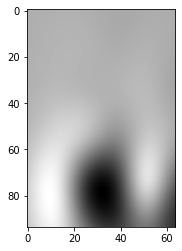

In [18]:
# Visualized the Displacement Field obtained from BSpline Transform

print(field.shape)
import matplotlib.pyplot as plt
plt.imshow(field[15, :, :, 0], cmap='gray')

In [6]:
# Visualize the results after RANSAC ICP

from itkwidgets import view

def readvtk(filename):
    a = vtk.vtkPolyDataReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

def readply(filename):
    a = vtk.vtkPLYReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

#m1 = readvtk('/home/pranjal.sahu/Documents/SampleApeData/USNM174701-Cranium_merged_1.vtk')
m1 = readvtk('fixedMesh.vtk')
#m2 = readvtk('/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium_1.vtk')
m2 = readvtk('ransacICPResult2_b.vtk')
#m3 = readvtk('ransacICPResult2_b_check.vtk')
m3 = readvtk('ransacICPResult2_c_check.vtk')


view(geometries=[m1, m2, m3])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [ ]:
# TSD registration

imageDiagonal   = 50
stretchWeight   = 0.0001
bendWeight      = 0.0001
geometricWeight = 0.0001
maxStep         = 1
numOfIterations = 20
learningRate    = 1

movingMesh = itk.meshread('movingMesh.vtk', itk.D)
fixedMesh  = itk.meshread('fixedMesh.vtk', itk.D)

print('Number of Points are')
print(movingMesh.GetNumberOfPoints())
print(fixedMesh.GetNumberOfPoints())

fixedMesh.BuildCellLinks()
movingMesh.BuildCellLinks()

PixelType = itk.D
Dimension = 3

MeshType        = itk.Mesh[itk.D, Dimension]
FixedImageType  = itk.Image[PixelType, Dimension]

# For getting the Bounding Box
ElementIdentifierType = itk.UL
CoordType = itk.F
Dimension = 3

VecContType = itk.VectorContainer[
    ElementIdentifierType, itk.Point[CoordType, Dimension]
]
bounding_box = itk.BoundingBox[ElementIdentifierType, Dimension, CoordType, VecContType].New()
bounding_box.SetPoints(movingMesh.GetPoints())
bounding_box.ComputeBoundingBox()

minBounds = np.array(bounding_box.GetMinimum())
maxBounds = np.array(bounding_box.GetMaximum())


spacing = np.sqrt(bounding_box.GetDiagonalLength2()) / imageDiagonal
diff = maxBounds - minBounds

print('Spacing ', spacing)
print('minBounds ', minBounds)
print('maxBounds ', maxBounds)

fixedImageSize    = [0]*3
fixedImageSize[0] = math.ceil( 1.2 * diff[0] / spacing )
fixedImageSize[1] = math.ceil( 1.2 * diff[1] / spacing )
fixedImageSize[2] = math.ceil( 1.2 * diff[2] / spacing )

fixedImageOrigin    = [0]*3
fixedImageOrigin[0] = minBounds[0] - 0.1 * diff[0]
fixedImageOrigin[1] = minBounds[1] - 0.1 * diff[1]
fixedImageOrigin[2] = minBounds[2] - 0.1 * diff[2]

fixedImageSpacing   = np.ones(3)*spacing
fixedImageDirection = np.identity(3)


fixedImage = FixedImageType.New()
fixedImage.SetRegions(fixedImageSize)
fixedImage.SetOrigin( fixedImageOrigin )
fixedImage.SetDirection( fixedImageDirection )
fixedImage.SetSpacing( fixedImageSpacing )
fixedImage.Allocate()


# Create BSpline Transformation object and initialize the parameters
SplineOrder = 3
TransformType  = itk.BSplineTransform[itk.D, Dimension, SplineOrder]
InitializerType = itk.BSplineTransformInitializer[TransformType, FixedImageType]

transform = TransformType.New()

# Higher the grid dimensio, slower the computation but higher will be the accuracy
numberOfGridNodesInOneDimension = 8
transformInitializer = InitializerType.New()
transformInitializer.SetTransform(transform)
transformInitializer.SetImage(fixedImage)
transformInitializer.SetTransformDomainMeshSize(numberOfGridNodesInOneDimension - SplineOrder)
transformInitializer.InitializeTransform()



MetricType = itk.ThinShellDemonsMetricv4.MD3
metric = MetricType.New()
metric.SetStretchWeight(stretchWeight)
metric.SetBendWeight(bendWeight)
metric.SetGeometricFeatureWeight(geometricWeight)
metric.UseConfidenceWeightingOn()
metric.UseMaximalDistanceConfidenceSigmaOff()
metric.UpdateFeatureMatchingAtEachIterationOn()
metric.SetMovingTransform(transform)
# Reversed due to using points instead of an image
# to keep semantics the same as in itkThinShellDemonsTest.cxx
# For the ThinShellDemonsMetricv4 the fixed mesh is regularized
metric.SetFixedPointSet(movingMesh)
metric.SetMovingPointSet(fixedMesh)
metric.SetVirtualDomainFromImage(fixedImage)
metric.Initialize()

print('TSD Metric Created')


optimizer = itk.RegularStepGradientDescentOptimizerv4.D.New()
optimizer.SetNumberOfIterations( numOfIterations )
optimizer.SetMaximumStepSizeInPhysicalUnits( maxStep )
optimizer.SetLearningRate(learningRate)
optimizer.SetMinimumConvergenceValue( 0.0 )
optimizer.SetConvergenceWindowSize( numOfIterations )

def iteration_update():
    metric_value = optimizer.GetValue()
    current_parameters = optimizer.GetCurrentPosition()
    print(f"Metric: {metric_value:.8g}")

iteration_command = itk.PyCommand.New()
iteration_command.SetCommandCallable(iteration_update)
optimizer.AddObserver(itk.IterationEvent(), iteration_command)


print('Number of Transform Parameters ', transform.GetNumberOfParameters())

AffineRegistrationType = itk.ImageRegistrationMethodv4.REGv4D3D3TD3D3MD3.New()
registration = AffineRegistrationType.New()
registration.SetNumberOfLevels(1)
registration.SetObjectName("registration")
registration.SetFixedPointSet(movingMesh)
registration.SetMovingPointSet(fixedMesh)
registration.SetInitialTransform(transform)
registration.SetMetric(metric)
registration.SetOptimizer(optimizer)
registration.InPlaceOn()

print('Registration Object created')
print('Initial Value of Metric ', metric.GetValue())

try:
    registration.Update()
except e:
    print('Error is ', e)

print('Final Value of TSD Metric ', metric.GetValue())


# Get the Displacement field from the BSpline Transform
finalTransform = registration.GetModifiableTransform()
convertFilter = itk.TransformToDisplacementFieldFilter.IVF33D.New()
convertFilter.SetTransform(finalTransform)
convertFilter.UseReferenceImageOn()
convertFilter.SetReferenceImage(fixedImage)
convertFilter.Update()
field = convertFilter.GetOutput()
field = np.array(field)
np.save('displacement_field.npy', field)

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedMesh)
e_metric.SetMovingPointSet(movingMesh)
print('Euclidean Metric Before TSD Deformable Registration ', e_metric.GetValue())

numberOfPoints = movingMesh.GetNumberOfPoints()
for n in range(0, numberOfPoints):
    movingMesh.SetPoint(n, finalTransform.TransformPoint(movingMesh.GetPoint(n)))

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedMesh)
e_metric.SetMovingPointSet(movingMesh)
print('Euclidean Metric After TSD Deformable Registration ', e_metric.GetValue())

itk.meshwrite(movingMesh, 'result_bspline.vtk')

In [ ]:
# Visualize the fixed mesh, moving mesh and the registered mesh

a = vtk.vtkPolyDataReader()
a.SetFileName('ransacICPResult2.vtk')
a.Update()
m1 = a.GetOutput()

a = vtk.vtkPolyDataReader()
a.SetFileName('result_bspline.vtk')
a.Update()
m2 = a.GetOutput()

a = vtk.vtkPolyDataReader()
a.SetFileName('fixedMesh.vtk')
a.Update()
m3 = a.GetOutput()

itkwidgets.view(geometries=[m1, m2, m3])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [4]:
#finalTransform = registration.GetModifiableTransform()
convertFilter = itk.TransformToDisplacementFieldFilter.IVF33D.New()
convertFilter.SetTransform(final_transform)
convertFilter.UseReferenceImageOn()
convertFilter.SetReferenceImage(fixedImage)
convertFilter.Update()
field = convertFilter.GetOutput()
field = np.array(field)
np.save('displacement_field.npy', field)

NameError: name 'final_transform' is not defined

(24, 48, 29, 3)


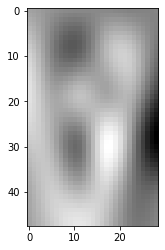

In [36]:
# Visualized the Displacement Field obtained from BSpline Transform

print(field.shape)
import matplotlib.pyplot as plt
plt.imshow(field[15, :, :, 0], cmap='gray')